In [1]:
%matplotlib inline
!git pull

from notebooks.lambda_imports import *

Already up to date.
PROJECT_PATH=C:\Users\javif\Coding\market_making_fw\python_lambda
BACKTEST_OUTPUT_PATH(LAMBDA_OUTPUT_PATH)=X:\output_models
BACKTEST_TEMP_PATH(LAMBDA_TEMP_PATH)=C:\Users\javif\Coding\temp
BACKTEST_JAR_PATH(LAMBDA_JAR_PATH)=C:\Users\javif\Coding\market_making_fw\java\executables\Backtest\target\Backtest.jar
log_path(LAMBDA_LOGS_PATH)=C:\Users\javif\Coding\market_making_fw\python_lambda\logs
PARQUET_PATH_DB(LAMBDA_PARQUET_TICK_DB)=X:\


In [2]:
first_hour=7
last_hour=19
quantity=0.0001
level_quote = 1#1-5 levels

instrument_pk='btcusdt_binance'
start_date=datetime.datetime(year=2022, day=18, month=8, hour=first_hour-1)
end_date=datetime.datetime(year=2022, day=18, month=8, hour=last_hour+1)

Algorithm.DELAY_MS=65#65 ms of slippage
Algorithm.FEES_COMMISSIONS_INCLUDED=False

# TickDB

In [3]:
tick = TickDB()
instruments = tick.get_all_instruments()
print(rf"TickDB has {len(instruments)} instruments")

depth_df = tick.get_depth(instrument_pk=instrument_pk,start_date=start_date,end_date=end_date)
trades_df = tick.get_trades(instrument_pk=instrument_pk,start_date=start_date,end_date=end_date)

TickDB has 29 instruments
downloading btcusdt_binance depth from 20220818 to 20220818
downloading btcusdt_binance trade from 20220818 to 20220818


<AxesSubplot:xlabel='date'>

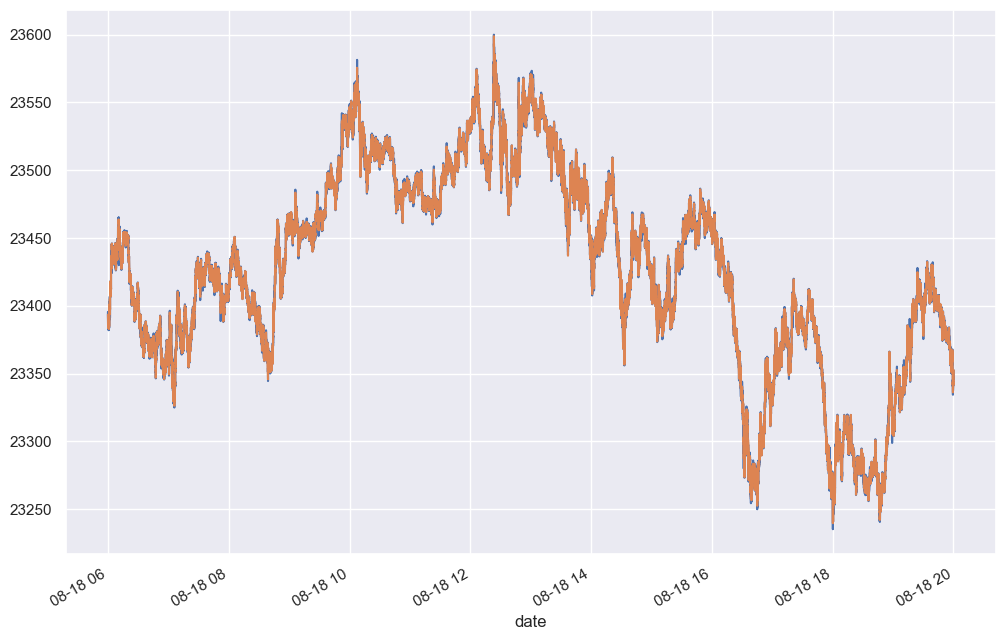

In [4]:
trades_df['price'][start_date:end_date].plot()
depth_df['midprice'][start_date:end_date].plot()

# Backtest Strategies

pwd=C:\Users\javif\Coding\market_making_fw\python_lambda\notebooks
ConstantSpread_constantSpread_0 finished with code 0
ConstantSpread_constantSpread_0 with 72421 trades
plotting trade_results from 2022-08-18 07:00:00.930000 to 2022-08-18 17:59:59.939000


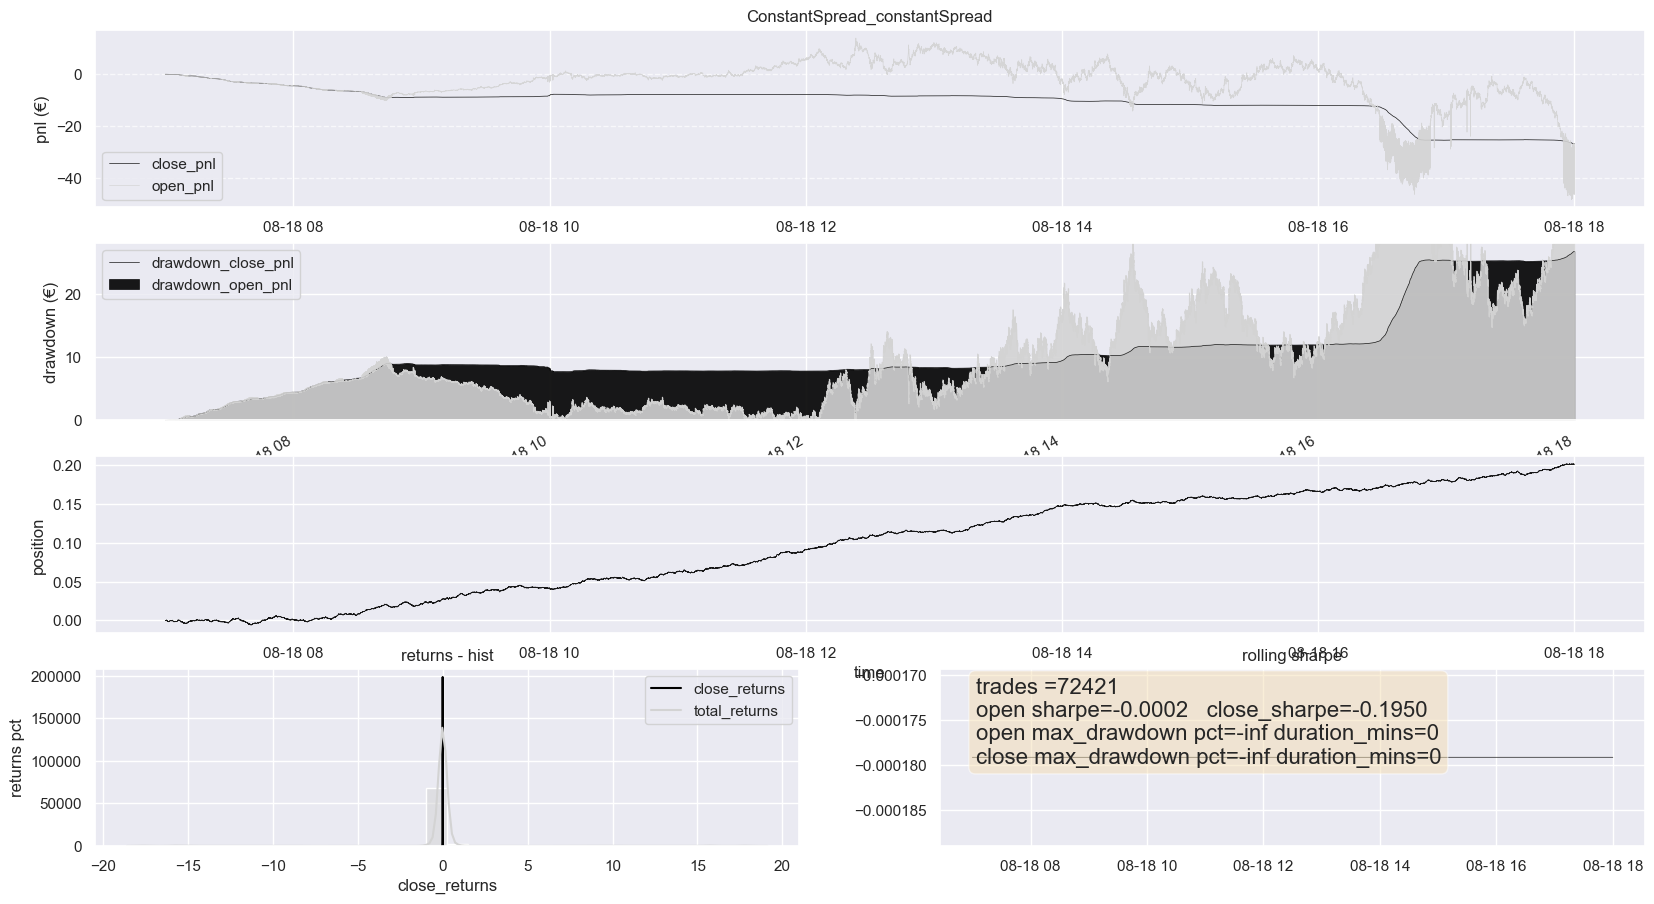

<Figure size 1200x800 with 0 Axes>

In [5]:
parameters_cs = {
    # ConstantSpread default
    "quantity": (quantity),
    "level": (level_quote),
    "quantityLimit": (-1),# no limit
    "firstHour": (first_hour),
    "lastHour": (last_hour),
}
constant_spread = ConstantSpread(algorithm_info='constantSpread')
constant_spread.set_parameters(parameters_cs)

constant_spread_test = constant_spread.test(
    instrument_pk=instrument_pk,
    start_date=start_date,
    end_date=end_date,
)
name_output = constant_spread.get_test_name(name=constant_spread.NAME)
cs_df = constant_spread_test[name_output]
output_plot=constant_spread.plot_trade_results(raw_trade_pnl_df=cs_df)

pwd=C:\Users\javif\Coding\market_making_fw\python_lambda\notebooks
LinearConstantSpread_linearConstantSpread_0 finished with code 0
LinearConstantSpread_linearConstantSpread_0 with 37233 trades
plotting trade_results from 2022-08-18 07:00:00.930000 to 2022-08-18 17:59:59.527000


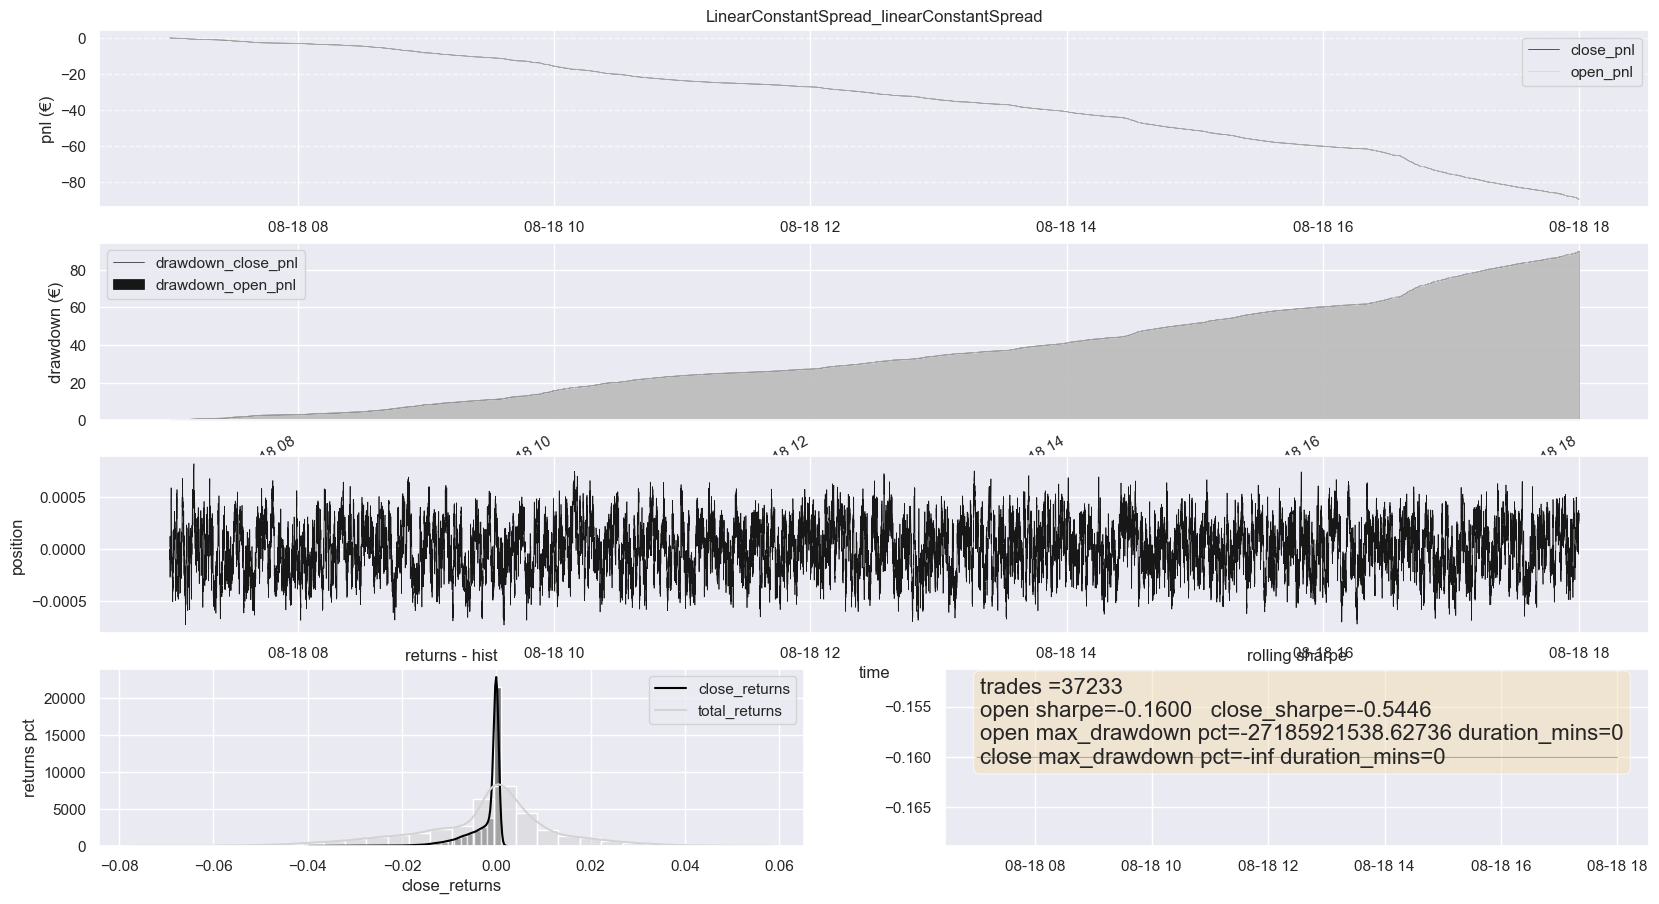

<Figure size 1200x800 with 0 Axes>

In [6]:
parameters_lcs = {
    # LinearConstantSpread default
    "quantity": (quantity),
    "level": (level_quote),
    "quantityLimit": (quantity*10),#10 times limit
    "firstHour": (first_hour),
    "lastHour": (last_hour),
}
linear_constant_spread = LinearConstantSpread(algorithm_info='linearConstantSpread')
linear_constant_spread.set_parameters(parameters_lcs)

linear_constant_spread_test = linear_constant_spread.test(
    instrument_pk=instrument_pk,
    start_date=start_date,
    end_date=end_date,
)
name_output = linear_constant_spread.get_test_name(name=linear_constant_spread.NAME)
lcs_df = linear_constant_spread_test[name_output]
output_plot_2=linear_constant_spread.plot_trade_results(raw_trade_pnl_df=lcs_df)

# Compare PnL

In [7]:
def join_two_timeseries_different_index_ffill(
    table_1: pd.DataFrame, table_2: pd.DataFrame
):
    concat_df = pd.concat([table_1,table_2],axis=1)
    concat_df.index = pd.to_datetime(concat_df.index)
    
    concat_df=concat_df.sort_index()
    concat_df=concat_df.fillna(method='ffill').fillna(0)
    return concat_df


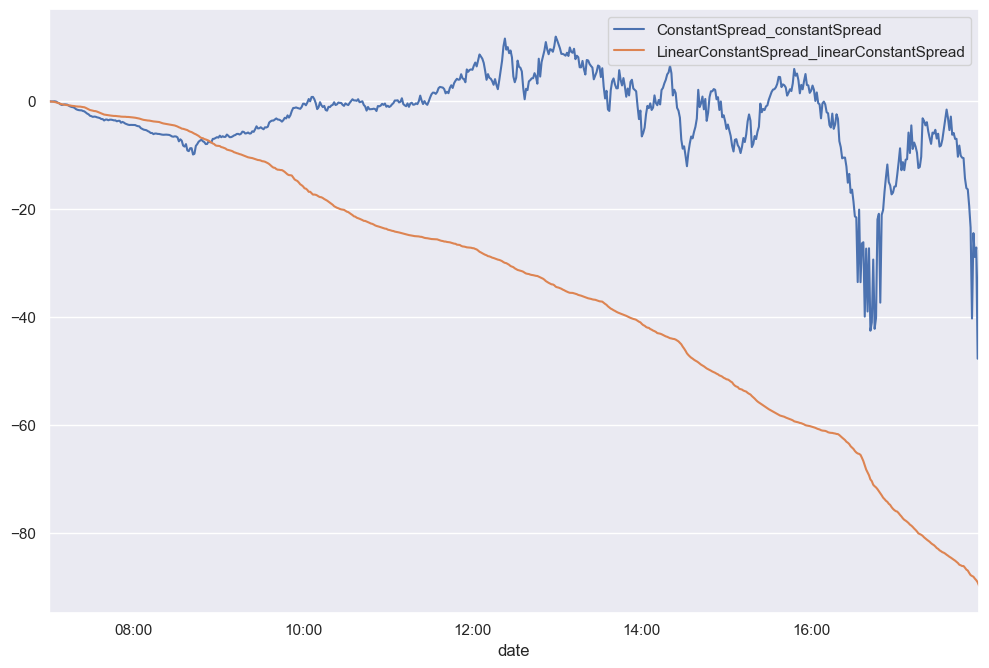

In [8]:
def compare_results_algorithms(backtest_test_output:list,column_to_compare='historicalTotalPnl',resample='1Min'):
    total_pnl=None
    legend=[]
    for backtest_test in backtest_test_output:
        name_output=list(backtest_test.keys())[0]
        backtest_result_test=backtest_test[name_output]
        
        backtest_result_test_indexed = copy.copy(backtest_result_test)
        backtest_result_test_indexed.set_index('date',inplace=True)
        
        series = backtest_result_test_indexed[column_to_compare]
        
        df = pd.DataFrame(series).rename(columns={column_to_compare:name_output})
        if total_pnl is None:
            total_pnl=df
        else:
            total_pnl=join_two_timeseries_different_index_ffill(total_pnl,df)

        legend.append(name_output)
    
    if resample is not None:
        total_pnl=total_pnl.resample(resample).last()

    return total_pnl    

        
compare_df = compare_results_algorithms(backtest_test_output=[constant_spread_test,linear_constant_spread_test])  
compare_df.plot()
plt.legend()